# Machine Learning in Python - Workshop 10

In this week's workshop we will be exploring several methods for unsupervised learning, specifically some of sklearn's tools for clustering data. 

# 1. Setup


## 1.1 Packages


In the cell below we will load the core libraries we will be using for this workshop and setting some sensible defaults for our plot size and resolution. 

In [ ]:
# Display plots inline
%matplotlib inline

# Data libraries
import pandas as pd
import numpy as np

# Plotting libraries
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# ipywidgets 
from ipywidgets import interact

# Plotting defaults
plt.rcParams['figure.figsize'] = (10,6)
plt.rcParams['figure.dpi'] = 80

# sklearn modules
import sklearn
import sklearn.cluster
import sklearn.manifold
import sklearn.preprocessing
from sklearn.compose import make_column_transformer
from sklearn.pipeline import make_pipeline
from scipy.cluster.hierarchy import dendrogram
import scipy.cluster

## 1.2 Helper Functions

For this lab we will make use of a the `plot_dendrogram` function provided in sklearn's clustering documentation. This function takes an `AgglomerativeClustering` model and plots the hierarchical merging of clusters as a dendrogram, more on this later.

In [ ]:
def get_labels(m):
    if hasattr(m, 'labels_'):
        return(m.labels_)
    else:
        return(m.steps[-1][1].labels_)
    

def plot_dendrogram(model, **kwargs):
    # Create linkage matrix and then plot the dendrogram
    # from sklearn documentaion:
    # https://scikit-learn.org/stable/auto_examples/cluster/plot_agglomerative_dendrogram.html
    
    # create the counts of samples under each node
    
    if (type(model) == sklearn.pipeline.Pipeline):
        model = model.steps[-1][1]
    
    counts = np.zeros(model.children_.shape[0])
    labels = get_labels(model)
    n_samples = len(labels)
    
    
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1  # leaf node
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    Z = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    palette = [mpl.colors.rgb2hex(c) for c in sns.color_palette(n_colors = model.n_clusters_)]
    
    link_cols = {}
    for i, i12 in enumerate(Z[:,:2].astype(int)):
        c1, c2 = (link_cols[x] if x > len(Z) else palette[labels[x]] for x in i12)
        link_cols[i+1+len(Z)] = c1 if c1 == c2 else "#808080"
    
    # Plot the corresponding dendrogram
    dendrogram(Z, link_color_func=lambda x: link_cols[x], **kwargs)
    
    
    if (model.n_clusters_ == 1):
        threshold = np.max(model.distances_)
    elif (model.distance_threshold is None):
        i = model.n_clusters_-1
        threshold = (model.distances_[-i] + model.distances_[-(i+1)])/2
    else:
        threshold = model.distance_threshold
    
    plt.axhline(y=threshold, color="0.25", linestyle="--")

## 1.3 Data

We will look at several toy data examples to start to get a better understanding of sklearn's clustering algorithms.

In [ ]:
data = {
    "d1": pd.read_csv("d1.csv"),
    "d2": pd.read_csv("d2.csv"),
    "d3": pd.read_csv("d3.csv"),
    "d4": pd.read_csv("d4.csv"),
    "d5": pd.read_csv("d5.csv"),
    "d6": pd.read_csv("d6.csv"),
}

In all six of the data sets we have observations in 2 dimensions with 1, 2, or 3 classes. Our goal will be to attempt to recover these labels as best we are able without providing the true labels to the underlying algorithm fitting our model(s), which is why these methods are called as unsupervised. 

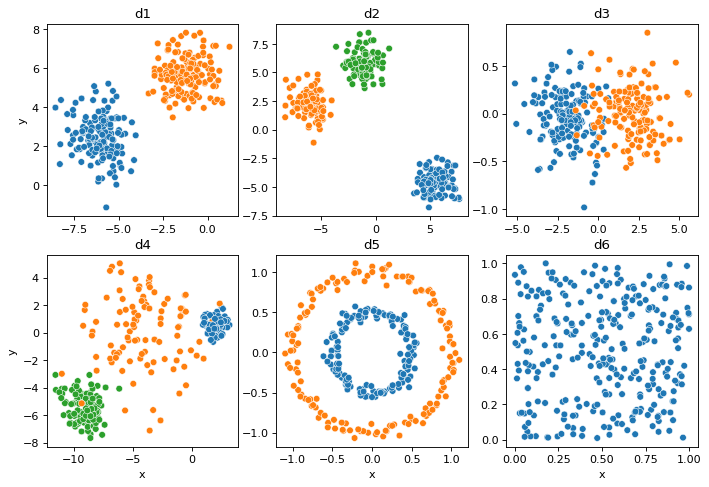

In [ ]:
plt.figure(figsize=(10.5,7))

for i, d in zip(range(len(data)), data):
    plt.subplot(231+i)
    ax = sns.scatterplot(x='x', y='y', hue='label', data=data[d], legend=False)
    ax.set_title(d)
    if (i < 3): ax.set_xlabel("")
    if (i % 3 != 0): ax.set_ylabel("")
    
plt.show()

---

# 2. K-Means

We will begin by fitting k-means models to the data sets while adjusting several of the key model parameters. k-means models are straight forward to fit and use a the same sklearn interface that we are used to, they only differ in that they only require a model / data matrix `X` and do not require or use the outcome vector `y`. For the sake of compatibility with the supervised models in sklearn the `fit` method of these models still has an argument `y`, but this is argument is neither required nor used. 

Since we are often only interested in the result of the clustering, and not the underlying model, k-means and the other clustering models offer a `fit_predict` method which both fits the model and then predicts cluster labels as a single step for a data matrix `X`. This is similar in spirit to the `fit_transform` method that is present with the preprocessing transformer like `StandardScaler` and `OneHotEncoder`.

Below we implement a function for exploring all six data sets with the k-means algorithm. Try changing the number of clusters and the method for initializing the cluster centroids (for more on the k-means++ method see this [article](https://en.wikipedia.org/wiki/K-means%2B%2B#Improved_initialization_algorithm)) and the random state value to seed the random number generator before fitting the model.

In [ ]:
def fit_kmeans(d='d1', n_clusters=2, init='random', random_state='1234'):
    # Convert from string to int
    random_state = int(random_state)
    n_clusters = int(n_clusters)
    
    df = data[d]
    X = df.drop(['label'], axis=1)

    # Fit and predict
    df['cluster'] = sklearn.cluster.KMeans(
        n_clusters=n_clusters, init=init, random_state=random_state
    ).fit_predict(X)
    df = df.astype({'cluster': 'category'})
    
    # Plot
    plt.figure(figsize=(7,7))
    ax = sns.scatterplot(x='x', y='y', hue='cluster', style='label', data=df)
    ax.set_title(d)
    
    plt.show()

---

### &diams; Exercise 1

For data set `d1` what happens when you change the value of `random_state` with `n_clusters=2`? *Hint* - keep trying until something interesting happens.

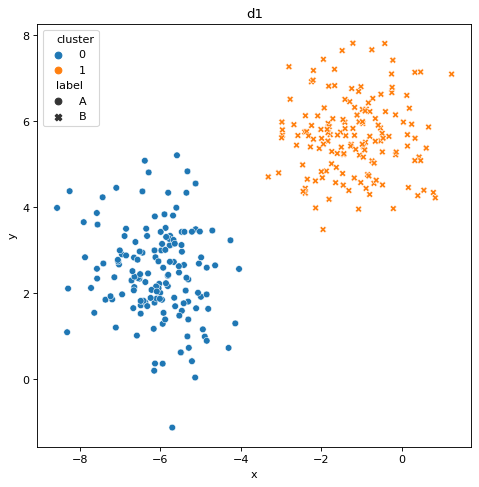

In [ ]:
fit_kmeans('d1', n_clusters=2, init='random', random_state=1234)

*For some values of random_state the predicted labels for the clusters will swap - sometimes blue is in the lower left sometimes orange.*

---

### &diams; Exercise 2

For data set `d1` set `n_clusters=3` do the clusters change as you vary `init` and `random_state`?

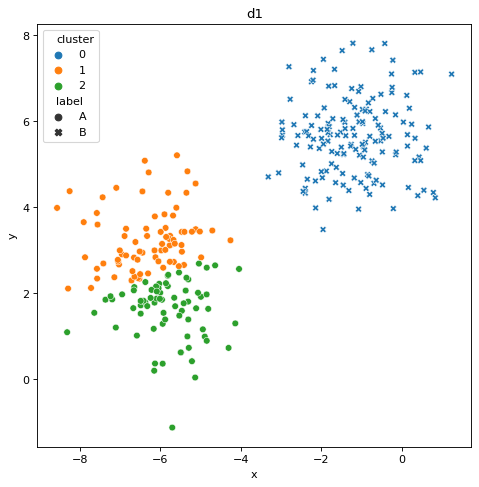

In [ ]:
fit_kmeans('d1', n_clusters=3, init='random', random_state=1234)

*The clusters do change very subtly along the boundary in the lower left, at a gross level the clusters do not change meaningfully - the lower left point cloud is always split. This happens for either value of `init` and various `random_state`s.*

---

### &diams; Exercise 3

Explore the different data sets with different values of `n_cluster`, describe the nature of the boundaries produced by a k-means clustering. *Hint* - don't just consider the binary (`k=2`) case.

*The clusters are separated by sharp linear boundaries that are equidistant from each of the centroid pairs - this creates a [Voronoi tessellation](https://en.wikipedia.org/wiki/Voronoi_diagram) of the space.*

---

### &diams; Exercise 4

Based on what we have just seen and what you have learned from the lectures, explain why we can or cannot construct a confusion matrix using the predictions from the k-means model (for the purposes of model scoring).

*We should not directly construct a confusion matrix because the ordering of the labels predicted by the model may not match our original labels. The resulting confusion matrix will potentially have the columns permuted. Additionally, this process can result in a non-square confusion matrix.*

---

In all of the provided data sets the true number of clusters is provided and is also fairly obvious by visual inspection of the data. However, with real world data this value is unlikely to be known ahead of time. A simple way of potentially determining this value is to fit a series of k-means models with different values of `k` an then comparing the resulting within-cluster sum-of-squares (or what sklearn calls the inertia).


---

### &diams; Exercise 5

In general, would you expect the within-cluster sum-of-squares (inertia) to increase, decrease or stay the same as `k` is increased?

*As the number of clusters increases we expect the inertia to decrease (or stay the same).*

---

Below we have reused the code from our previous function but now we include a second plot that shows the inertia as a function of `n_cluster`. For each of the data sets play with different values of `n_clusters` and try to develop some intuition on how the inertia relates to the model's fit.

In [ ]:
def fit_kmeans_inertia(d = 'd1', n_clusters=2):
    # Read the data, create the model matrix, and fit and predict
    df = data[d]
    X = df.drop(['label'], axis=1)
    
    models = [ sklearn.cluster.KMeans(n_clusters=n).fit(X) for n in range(1,6)]
    scores = [m.inertia_ for m in models]
    
    df['cluster'] = models[n_clusters-1].predict(X)
    df = df.astype({'cluster': 'category'})
    
    # Plot
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    sns.scatterplot(x='x', y='y', hue='cluster', style='label', data=df)
    
    plt.subplot(122)
    plt.plot(np.arange(1,6), scores, 'o-')
    plt.xlabel("n_clusters")
    plt.ylabel("inertia")
    plt.xticks(range(1,6))
    
    plt.show()

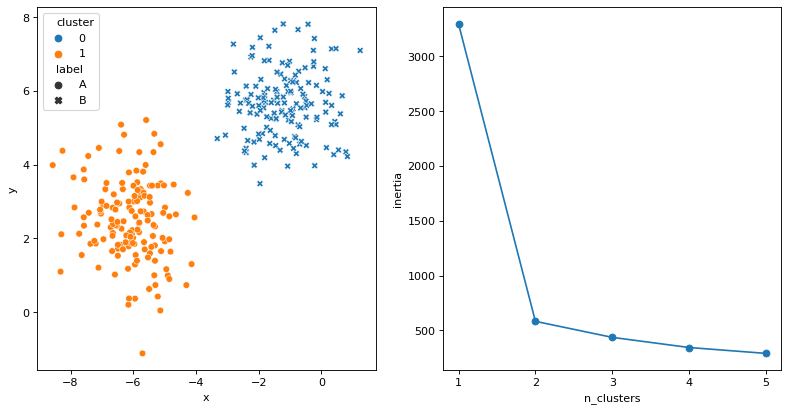

In [ ]:
fit_kmeans_inertia('d1', n_clusters=2)

---

### &diams; Exercise 6

Based on these plots, for which data sets does k-means appear to be doing a good job - i.e. it fits well and the correct number of clusters can be inferred from the data. For which data sets does it not do a good job?

*d1 & d2 work well, d3 & d4 work reasonably well, and d5 & d6 fail spectacularly.*

---

### &diams; Exercise 7

Describe the features of the inertia plots that suggest whether a k-means model is fitting well and how this relates to determining $n_{clusters}$.

*Generally a sharp elbow like pattern in the data is suggestive of the model fitting well (seen clearly with d1 and d2). The location of the elbow suggests the "optimal" value for n_clusters. In the case where the model fails seeing a steep continual decrease suggests poor performance.*

# 3. Hierarchical Clustering

While there is a large number of different methods for hierarchical clustering, the methods implemented in sklearn under the `AgglomerativeClustering` model use a bottom up approach by starting each observation as its own cluster and then merging existing clusters to create new larger clusters. The rule(s) used for merging these clusters are determined by the `linkage` argument which takes one of the following values:

* `"ward"` - minimizes the sum of squared differences within all clusters.
* `"complete"` - minimizes the maximum distance between observations of pairs of clusters.
* `"average"` - minimizes the average of the distances between all observations of pairs of clusters.
* `"single"` - minimizes the distance between the closest observations of pairs of clusters.

Below we define a function that will let you play with these different approaches. The function also provides the option of specifying either `n_clusters` or `distance_threshold` - the former is ignored if the latter is not `None` or `""`.

In [ ]:
def fit_aggclust(d='d1', n_clusters=2, distance_threshold=None, linkage='ward'):
    #distance_threshold = float(distance_threshold)
    
    try:
        distance_threshold = float(distance_threshold)
    except:
        distance_threshold = None
    
    if (distance_threshold is not None):
        n_clusters = None
    
    d = data[d]
    X = d.drop(['label'], axis=1)
    
    # Fit model
    m = sklearn.cluster.AgglomerativeClustering(
        distance_threshold=distance_threshold, n_clusters=n_clusters, 
        linkage=linkage, compute_full_tree = True, compute_distances = True
    ).fit(X)
    
    d['cluster'] = m.labels_
    d['cluster'] = d['cluster'].astype('category')
    
    # Plot
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)
    sns.scatterplot(x='x', y='y', hue='cluster', style='label', data=d)
    
    plt.subplot(122)
    plot_dendrogram(m, show_leaf_counts=False, no_labels=True)

    
    plt.show()

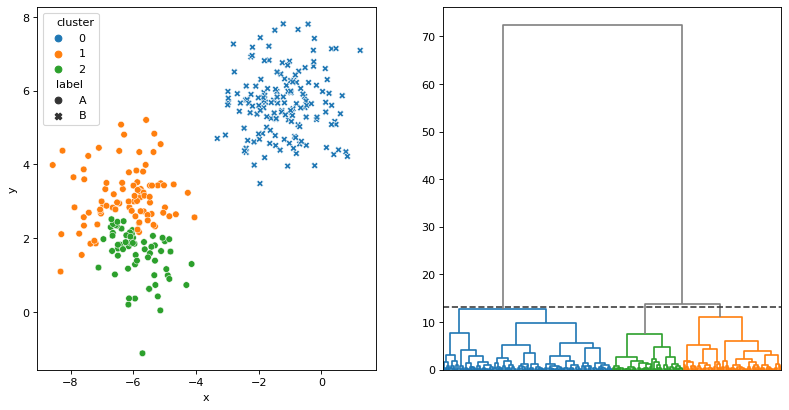

In [ ]:
fit_aggclust('d1', n_clusters=3, distance_threshold=None, linkage='ward')

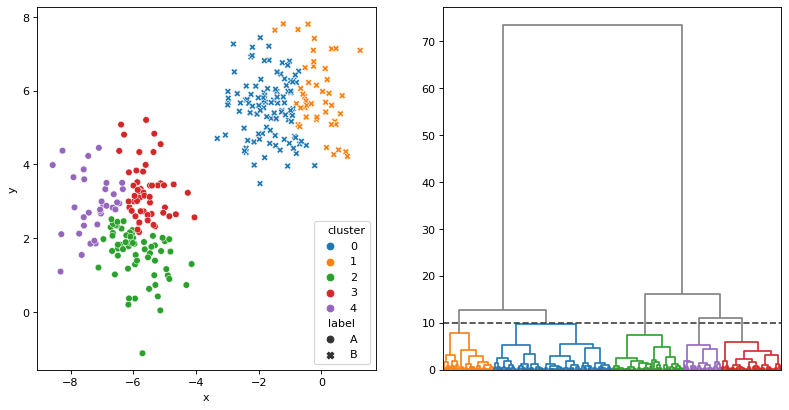

In [ ]:
fit_aggclust('d1', n_clusters=3, distance_threshold=10, linkage='ward')

---

### &diams; Exercise 8

How does the `distance_threshold` argument relate to the number of clusters predicted by the model?

*The number of clusters is determines by the dendrogram - i.e. the number of vertical lines intersected by the horizontal line at the threshold value.*

---

### &diams; Exercise 9

For `d1` and `d2` which of the linkage method(s) work best for identifying the correct number of clusters present?

*All of the linkage methods reasonably well identify 2 and 3 clusters respectively for these data.*

---

### &diams; Exercise 10

What about for `d3` and `d4`? Which of the linkage method(s) work best for identifying the correct number of clusters present?

- *"ward" - works well for both*
- *"complete" - works well for d3 for d4 appears to predict between 3 or 4 clusters.*
-  *"average" - appears to give a number of clusters in the neighborhood of the correct values (2 or 3 for d3 and 3 or 4 for d4)*
-  *"single" - does not appear to work well for either data set*

---

### &diams; Exercise 11

Finally, what about for `d5` and `d6`?

- *"ward" - fails for both*
- *"complete" - fails for both*
- *"average" - fails for both*
- *"single" - works for d5 and fails for d6*

---

### &diams; Exercise 12

Based on what you found with Exercises 9-11 can you come up with a reasonable heuristic for choosing which linkage function to use?

*Generally when the data is structured such that there are clear clusters then "ward" will generally work well, when the data has a more complex structure then potentially "single" may work.*

*Some additional details on these methods can be found in the sklearn user guide here*

---

# 4. Clustering Animals

We will wrap this workshop up by looking at a slightly more complicated example. These data come from the `palmerpenguin` R [package](https://github.com/allisonhorst/palmerpenguins) by Allison Horst and represent data collected on penguin species occuring around Palmer Station in Antarctica by Dr. Kristen Gorman. The data contain various measurement details of the sample penguin's physical characteristics as well as the specific island they were located on. The data provided in `palmerpenguin.csv` reflect a lightly modified version of the data available in the package (missing values and the `year` variable have been removed.)

In [ ]:
penguin = pd.read_csv("palmerpenguins.csv")
penguin

,species,island,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex
0,Adelie,Torgersen,39.1,18.7,181,3750,male
1,Adelie,Torgersen,39.5,17.4,186,3800,female
2,Adelie,Torgersen,40.3,18.0,195,3250,female
3,Adelie,Torgersen,36.7,19.3,193,3450,female
4,Adelie,Torgersen,39.3,20.6,190,3650,male
...,...,...,...,...,...,...,...
328,Chinstrap,Dream,55.8,19.8,207,4000,male
329,Chinstrap,Dream,43.5,18.1,202,3400,female
330,Chinstrap,Dream,49.6,18.2,193,3775,male
331,Chinstrap,Dream,50.8,19.0,210,4100,male


Our goal is to now use the clustering methods we've just learned and see how well we are able to distinguish between the different species of penguin using an *unsupervised* modelling approach. Specifically, in this case we already know the species, but it is conceivable that a similar project could have been undertaken where the question of interest is how many species are present amoung the sampled individuals.

Below we set up a dictionary containing two pipelines, one for agglomerative clustering and the other for k means clustering. These pipelines are configured so that they take care of the dummy coding for the categorical variables and the basic configuration of the clustering models.

In [ ]:
models = {
    "AgglomerativeClustering": make_pipeline(
        make_column_transformer(
            (sklearn.preprocessing.OneHotEncoder(), ['island', 'sex']),
            remainder = "passthrough"
        ),
        sklearn.cluster.AgglomerativeClustering(
            compute_full_tree = True, compute_distances = True
        )
    ),
    "KMeans": make_pipeline(
        make_column_transformer(
            (sklearn.preprocessing.OneHotEncoder(), ['island', 'sex']),
            remainder = "passthrough"
        ),
        sklearn.cluster.KMeans()
    )
}

We will now setup a function which allows us to explore the model of our choice and change the basic parameters `n_clusters` for both and `linkage` for the agglomerative clustering. The function will then report the performance of the model by showing the allocation of species within each of the predicted clusters as well as show the calculated homogenity and completeness of these clusters. In the case of the agglomerative clustering, a dendrogram of the cluster will also be shown.

In [ ]:
def fit_penguin(m, n_clusters=4, linkage="ward"):
    m = models[m]
    
    model_type = m.steps[-1][0]
    params = {}
    params[model_type+"__n_clusters"] = n_clusters
    
    if (model_type == "agglomerativeclustering"):
        params[model_type+"__linkage"] = linkage
    
    m.set_params(**params)
    
    
    # Fit model
    X = penguin.drop(["species"], axis=1)
    m_fit = m.fit(X)
    
    # Calc scores
    homogenity = sklearn.metrics.homogeneity_score(penguin.species, get_labels(m_fit))
    completeness = sklearn.metrics.completeness_score(penguin.species, get_labels(m_fit))
    
    # Count species in clusters
    pred = pd.DataFrame(penguin.species)
    pred["cluster"] = get_labels(m_fit)
    
    clusters = pred.value_counts(sort=False).rename("n").to_frame().reset_index()
    
    # Plot
    plt.figure(figsize=(12,6))
    
    plt.subplot(121)    
    ax = sns.barplot(x="cluster", y ="n", hue="species", data = clusters, palette = sns.color_palette("Set2"))
    ax.set_title("Homogenity: {:.3f},   Completeness: {:.3f}".format(homogenity, completeness))
    
    
    if (model_type == "agglomerativeclustering"):
        plt.subplot(122)
        plot_dendrogram(m, no_labels = True)
    
    plt.show()

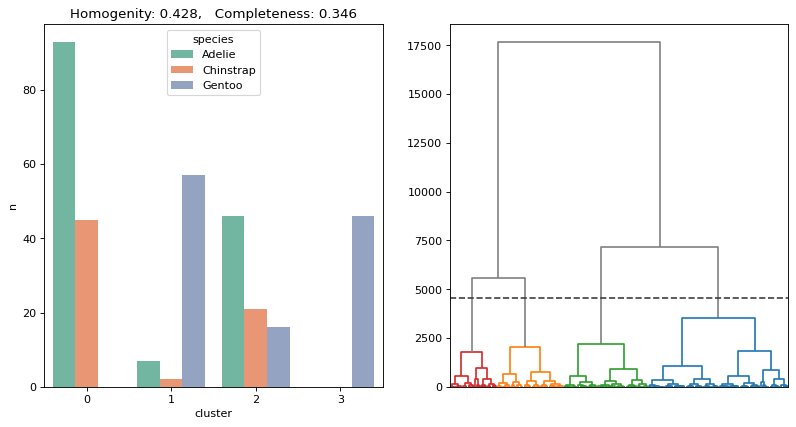

In [ ]:
fit_penguin('AgglomerativeClustering', n_clusters=4, linkage='ward')

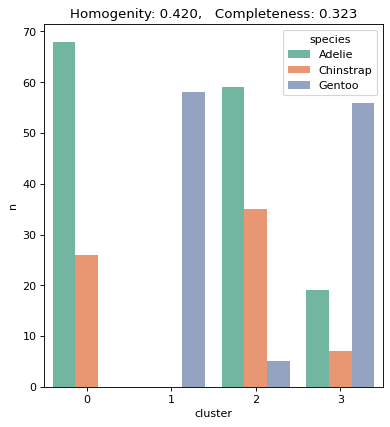

In [ ]:
fit_penguin('KMeans', n_clusters=4, linkage='ward')

---

### &diams; Exercise 13

Experimenting with the given parameter choices, which approach (if any) appears to do the best job of correctly identifying the three species?

*None of the clustering models appears to work very well - the agglomerative models appear a bit better than k means (except for `single` linkage). The models seem some what better at distinguishing the Gentoo and the Adelie penguins, but seems to have more difficulty with the Chinstrap. 3 clusters as expected gives the best combined "scores" for homogeneity and completeness.*

---

### &diams; Exercise 14

We have previously seen that certain machine learning methods are sensitive to the scaling of the features, do you believe this is likely to be the case here, explain why or why not.

*Yes these models are likely to be quite sensitive to the scale of the features as we are using "distance" between the points to determine the clusters.*

---

### &diams; Exercise 15

Add two new models to the `models` dictionary that implements scaling of the numeric features as part of the pipeline (e.g. use `sklearn.preprocessing.StandardScaler`), name these `KMeans_Scaled` respectively.

Does this improve the performance of the clustering? Which approach (if any) now appears to be best?

In [ ]:
# Example of a revised model dictionary

models = {
    "AgglomerativeClustering": make_pipeline(
        make_column_transformer(
            (sklearn.preprocessing.OneHotEncoder(), ['island', 'sex']),
            remainder = "passthrough"
        ),
        sklearn.cluster.AgglomerativeClustering(
            compute_full_tree = True, compute_distances = True
        )
    ),
    "KMeans": make_pipeline(
        make_column_transformer(
            (sklearn.preprocessing.OneHotEncoder(), ['island', 'sex']),
            remainder = "passthrough"
        ),
        sklearn.cluster.KMeans()
    ),
    "AgglomerativeClustering_Scaled": make_pipeline(
        make_column_transformer(
            (sklearn.preprocessing.OneHotEncoder(), ['island', 'sex']),
            remainder = sklearn.preprocessing.StandardScaler()
        ),
        sklearn.cluster.AgglomerativeClustering(
            compute_full_tree = True, compute_distances = True
        )
    ),
    "KMeans_Scaled": make_pipeline(
        make_column_transformer(
            (sklearn.preprocessing.OneHotEncoder(), ['island', 'sex']),
            remainder = sklearn.preprocessing.StandardScaler()
        ),
        sklearn.cluster.KMeans()
    ),
}

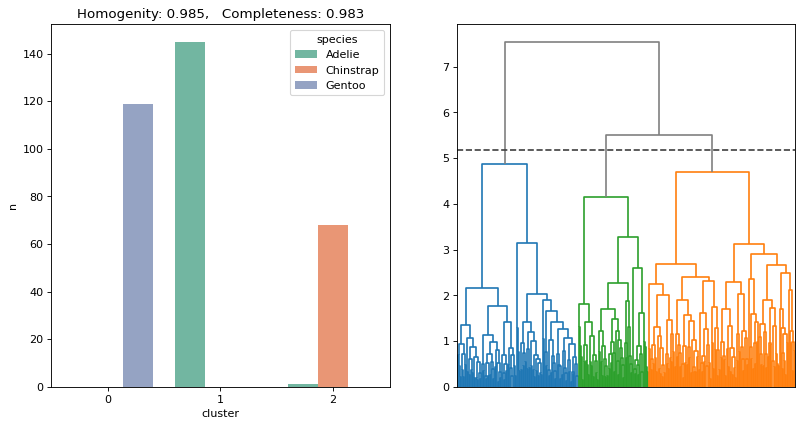

In [ ]:
fit_penguin("AgglomerativeClustering_Scaled", n_clusters=3, linkage="complete")


*This definitely improves both of the clustering models' performance. K Means performs ok but seems to have difficulty distinguishing between some Adelie and Chinstrap penguins. Agglomerative clustering with `ward` linkage has slightly improved performance but suffers from similar issues. However, both `complete` and `average` linkage perform very well and correctly group almost all penguins by their species.*

---

## 4. Competing the worksheet

At this point you have hopefully been able to complete all the preceeding exercises. Now 
is a good time to check the reproducibility of this document by restarting the notebook's
kernel and rerunning all cells in order.

Once that is done and you are happy with everything, you can then run the following cell 
to generate your PDF and turn it in on gradescope under the `mlp-week10` assignment.

In [ ]:
!jupyter nbconvert --to pdf mlp-week10.ipynb

[NbConvertApp] Converting notebook mlp-week10.ipynb to pdf
[NbConvertApp] Support files will be in mlp-week10_files/
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Making directory ./mlp-week10_files
[NbConvertApp] Writing 73490 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 513952 bytes to mlp-week10.pdf


<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=259e33de-e84f-474c-84ff-6aa7e67c3513' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>